In [38]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Add, Multiply, Lambda, Reshape

In [45]:
IMAGE_LENGTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
LABELS = ['battery', 'cardboard', 'clothes', 'food', 'glass', 'medical', 'metal', 'paper', 'plastic', 'shoes']
BEST_MODEL_FILE_PATH = '../models/MOBNETv2-best_val_loss_model.h5'
LIVE_VIDEO_SRC = 0

In [35]:
def conv_block(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def depthwise_conv_block(inputs, expansion, strides):
    in_channels = inputs.shape[-1]
    
    x = Conv2D(expansion * in_channels, (1, 1), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = DepthwiseConv2D((3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(in_channels, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    if strides == (1, 1):
        x = Add()([x, inputs])
    
    return x

def MobileNetV2(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Preprocessing Lambda layer
    x = Lambda(lambda x: x / 127.5 - 1.0)(inputs)
    
    # First Convolution layer
    x = conv_block(x, 32, (3, 3), strides=(2, 2))
    
    # Inverted Residual Block 1
    x = depthwise_conv_block(x, 1, strides=(1, 1))
    x = depthwise_conv_block(x, 6, strides=(2, 2))
    
    # Inverted Residual Block 2
    x = depthwise_conv_block(x, 6, strides=(1, 1))
    x = depthwise_conv_block(x, 6, strides=(2, 2))
    
    # Inverted Residual Block 3
    x = depthwise_conv_block(x, 6, strides=(1, 1))
    x = depthwise_conv_block(x, 6, strides=(2, 2))
    
    # Inverted Residual Block 4
    x = depthwise_conv_block(x, 6, strides=(1, 1))
    x = depthwise_conv_block(x, 6, strides=(1, 1))
    x = depthwise_conv_block(x, 6, strides=(1, 1))
    x = depthwise_conv_block(x, 6, strides=(1, 1))
    x = depthwise_conv_block(x, 6, strides=(1, 1))
    
    # Inverted Residual Block 5
    x = depthwise_conv_block(x, 6, strides=(2, 2))
    x = depthwise_conv_block(x, 6, strides=(1, 1))
    
    # Last Convolution layer
    x = conv_block(x, 1280, (1, 1), strides=(1, 1))
    
    # Global Average Pooling and Dense layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, x)
    return model

# Create the MobileNetV2 model
input_shape = (IMAGE_HEIGHT, IMAGE_LENGTH, IMAGE_CHANNELS)
num_classes = 10
model = MobileNetV2(input_shape, num_classes)

model.compile(loss='squared_hinge', optimizer='adam', metrics=['categorical_accuracy', 'accuracy'])

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 100, 100, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 50, 50, 32)   896         ['lambda_1[0][0]']               
                                                                                                  
 batch_normalization_41 (BatchN  (None, 50, 50, 32)  128         ['conv2d_28[0][0]']        

In [36]:
model.load_weights(BEST_MODEL_FILE_PATH)

Class: Battery, Confidence: 100.0%


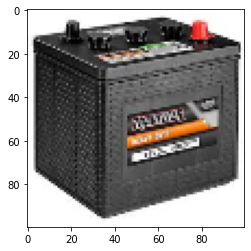

In [57]:
img_file_path = r"F:\Artificial Intelligence\Datasets\Garbage Seg V10\Dataset\test\battery\battery85.jpg"
image = cv2.imread(img_file_path)
rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(rgb_img, (IMAGE_HEIGHT, IMAGE_LENGTH))
features = np.reshape(resized_img, (1, IMAGE_HEIGHT, IMAGE_LENGTH, IMAGE_CHANNELS))
pred = model.predict(features)
arg_max = np.argmax(pred, axis=1)[0]
label_conf = pred[0][arg_max]
label = LABELS[arg_max]

plt.imshow(resized_img)
print(f'Class: {label.title()}, Confidence: {round(label_conf * 100, 0)}%')

In [55]:
camera = cv2.VideoCapture(LIVE_VIDEO_SRC)

while True:
    ret, frame = camera.read()

    if ret:
        rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(rgb_img, (IMAGE_HEIGHT, IMAGE_LENGTH))
        features = np.reshape(resized_img, (1, IMAGE_HEIGHT, IMAGE_LENGTH, IMAGE_CHANNELS))
        pred = model.predict(features)
        arg_max = np.argmax(pred, axis=1)[0]
        label_conf = pred[0][arg_max]
        label = LABELS[arg_max]

        cv2.putText(frame, f'Class: {label.title()}', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, f'Conf: {round(label_conf * 100, 0)}%', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.imshow('LIVE - GARBADGE SEGREGATION', frame)

        k = cv2.waitKey(1)
        if k == 27:
            break

camera.release()
cv2.destroyAllWindows()